In [1]:
import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PCA sul Wine Dataset

In [35]:
wine_dataset = sklearn.datasets.load_wine()

In [36]:
print(wine_dataset['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [37]:
X, y = wine_dataset['data'], wine_dataset['target']

In [38]:
X.shape

(178, 13)

In [39]:
y.shape

(178,)

In [40]:
df = pd.DataFrame(data=np.hstack((X, y.reshape(-1, 1))), columns=wine_dataset['feature_names']+['target'])

In [41]:
df['target'] = df['target'].astype('int32')

In [42]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [43]:
X_pca = PCA(n_components=2).fit_transform(X)

In [44]:
colors = {0: "r", 1: "b", 2: "g"}

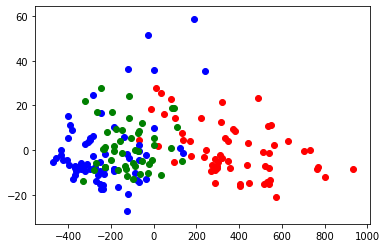

In [45]:
for i in range(y.size):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], color=colors[y[i]])

# Gradient descent

In [84]:
def get_gradient(X_batch, y_batch, w):
    ''' Ritorna il gradiente della loss MSE

    Params
    ------
    X (np.array n x f): sotto-matrice delle features (batch?)
    y (np.array n): targets associati
    w (np.array f): parametri

    Ret
    ---
    gradient (np.array)
    '''
    # vettore colonna
    assert y_batch.ndim == 2 and y_batch.shape[1]==1
    assert w.ndim == 2 and w.shape[1]==1

    return ((w.T@X_batch.T@X_batch)*2 - (y_batch.T@X_batch)*2).T

In [85]:
# generatore
def get_batch(X, y, batch_size):
    ''' Ritorna in sequenza i batch.
    L'ultimo può essere meno numeroso di batch_size

    Params
    ------
    X (np.array n x f): matrice delle features
    y (np.array n): targets
    batch_size: numero di campioni per batch

    Yield
    ------
    (X_batch, y_batch)
    X_batch (np.array batch_size x f): features del batch
    y_batch (np.array batch_size): targets del batch
    '''
    idx = 0
    while idx < X.shape[0]:
        yield(X[idx:idx+batch_size], y[idx:idx+batch_size])
        idx += batch_size

In [168]:
def linear_regression_grad_desc(X, y, w_0, lr, eps, max_epochs, batch_size):
    ''' Esegue un gradient descent

    Params
    ------
    X (np.array n x f): matrice delle features
    y (np.array n): targets
    w_0 (np.array f): parametri iniziali
    lr: learning rate
    eps: convergenza se |w_n-w_(n-1)|< eps
    max_epochs: numero massimo di epoche (si interrompe anche senza convergenza)
    batch_size: numero di campioni per batch

    Ret
    ---
    (convergence, w)
    convergence: bool. Se è stata raggiunta la convergenza
    w: i parametri finali
    '''
    # vettori colonna
    assert y.ndim == 2 and y.shape[1]==1
    assert w_0.ndim == 2 and w_0.shape[1]==1

    convergence = False
    w = np.copy(w_0)

    ws = [np.copy(w.ravel())]

    for epoch in range(max_epochs):
        w_start = np.copy(w)
        for X_batch, y_batch in get_batch(X, y, batch_size):
            gradient = get_gradient(X_batch, y_batch, w)
            w -= gradient * lr
            ws.append(np.copy(w.ravel()))
        # finita epoca
        if np.sqrt((w-w_start).T@(w-w_start)) < eps:
            convergence = True
            break

    return convergence, w, ws

In [ ]:
!wget https://github.com/btlgs2000/machine_learning_avanzato/blob/master/X_gd.npy

In [ ]:
!wget https://github.com/btlgs2000/machine_learning_avanzato/blob/master/y_gd.npy

In [2]:
X = np.load('X_gd.npy')
y = np.load('y_gd.npy')

In [3]:
X

array([[ 0.82944601, 75.0844131 ],
       [ 0.76702081, 82.17660854],
       [ 0.52739397, 70.19860907],
       ...,
       [ 0.30022792, 70.10432995],
       [ 0.41479062, 11.11254516],
       [ 0.32168468, 38.78901185]])

In [192]:
w_0=np.random.rand(2, 1)
convergence, w, ws = linear_regression_grad_desc(X, y.reshape(-1, 1), w_0=w_0, lr=1e-5, eps=1e-3, max_epochs=100, batch_size=32)

In [193]:
convergence

False

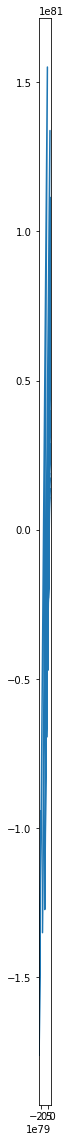

In [194]:
a = [v[0] for v in ws]
b = [v[1] for v in ws]
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.set_aspect('equal')
ax.plot(a, b)

# Regolarizzazione L2

In [44]:
n = 30
a, b = -np.pi, np.pi
X = np.sort(np.random.uniform(a, b, n)).reshape(-1, 1)
Y = np.sin(X) + np.random.randn(*X.shape)*0.1

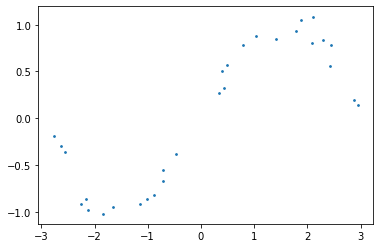

In [45]:
plt.scatter(X, Y, s=3)

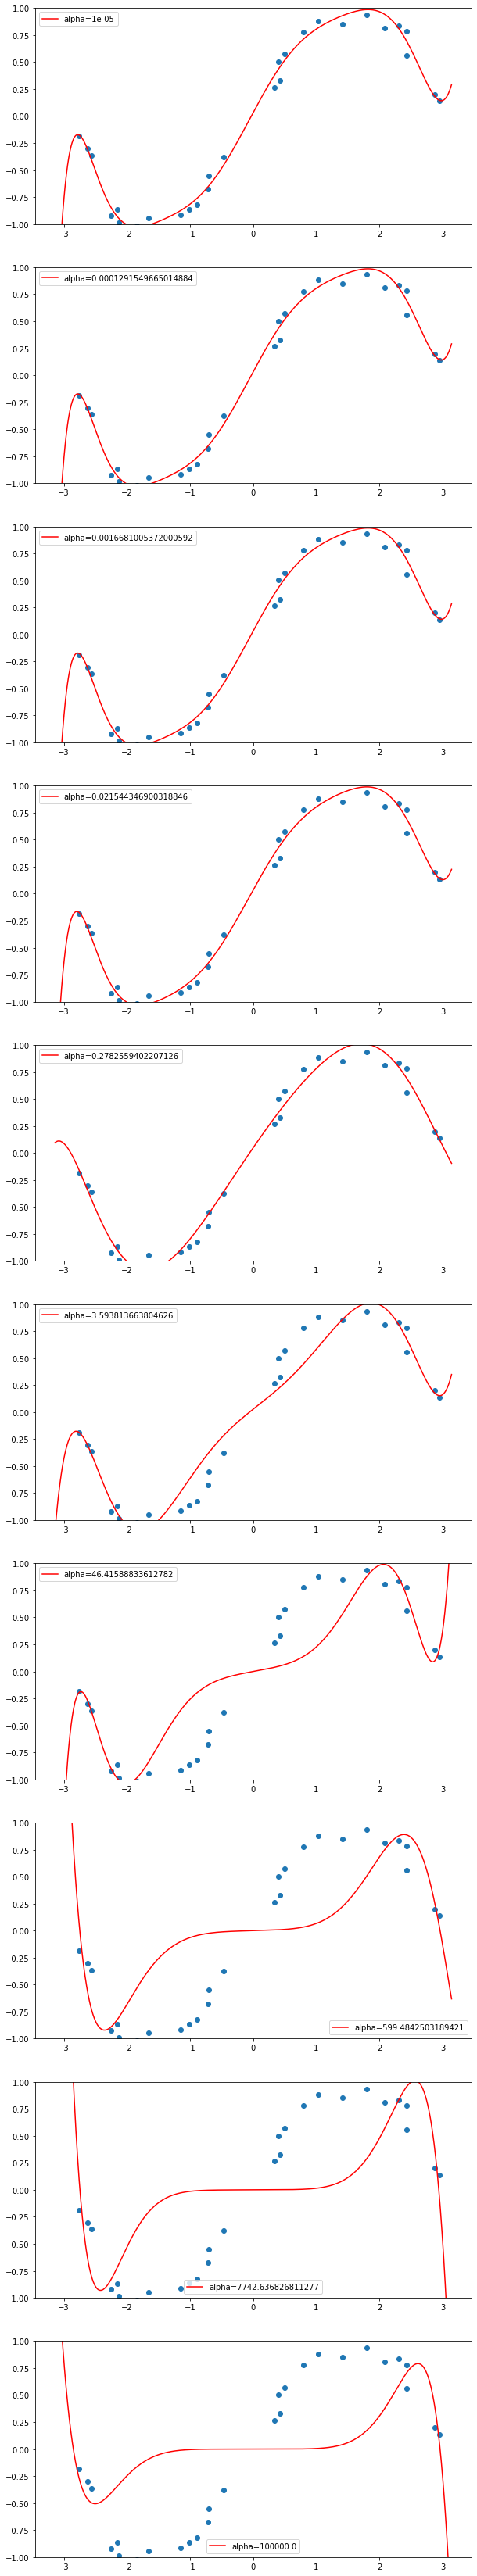

In [50]:
fig, axes = plt.subplots(10, 1, figsize=(10, 60))
coefs = []
for i, alpha in enumerate(np.logspace(-5, 5, 10)):
    degree = 10
    pf = PolynomialFeatures(degree=degree, include_bias=True)
    poly_X = pf.fit_transform(X)
    lr = Ridge(alpha=alpha, fit_intercept=False)
    lr.fit(poly_X, Y)
    coefs.append(lr.coef_)

    XX = np.linspace(a, b, 1000).reshape(-1, 1)
    poly_XX = np.hstack((XX**i for i in range(degree+1)))


    axes[i].scatter(X, Y)
    axes[i].plot(XX, poly_XX@lr.coef_.reshape(-1, 1), c='r', label=f'alpha={alpha}')
    axes[i].set_ylim(-1, 1)
    axes[i].legend()

In [51]:
coefs

[array([[ 3.25689706e-02,  1.08833257e+00, -7.55308070e-02,
         -3.77989364e-01,  5.43251182e-02,  1.18652307e-01,
         -1.97888612e-02, -1.97751715e-02,  3.28294885e-03,
          1.10839492e-03, -1.89388678e-04]]),
 array([[ 3.25890557e-02,  1.08814246e+00, -7.55463129e-02,
         -3.77709735e-01,  5.43077387e-02,  1.18537311e-01,
         -1.97770862e-02, -1.97571074e-02,  3.28072822e-03,
          1.10743097e-03, -1.89255530e-04]]),
 array([[ 3.28457093e-02,  1.08570051e+00, -7.57413544e-02,
         -3.74119101e-01,  5.40814893e-02,  1.17060863e-01,
         -1.96249801e-02, -1.95251943e-02,  3.25209997e-03,
          1.09505593e-03, -1.87540704e-04]]),
 array([[ 3.57593544e-02,  1.05624359e+00, -7.75451629e-02,
         -3.30984187e-01,  5.09582750e-02,  9.93537490e-02,
         -1.76794259e-02, -1.67463628e-02,  2.89344021e-03,
          9.46851438e-04, -1.66283618e-04]]),
 array([[ 4.86351527e-02,  8.50435203e-01, -7.36897210e-02,
         -4.82399058e-02,  2.0139962

In [59]:
poly_XX[0]

array([ 1.00000000e+00, -3.14159265e+00,  9.86960440e+00, -3.10062767e+01,
        9.74090910e+01, -3.06019685e+02,  9.61389194e+02, -3.02029323e+03,
        9.48853102e+03, -2.98090993e+04,  9.36480475e+04])

In [56]:
coefs[-1].shape

(1, 11)

In [60]:
np.mean(np.abs(poly_XX * coefs[-1]), axis=0)

array([3.49886442e-06, 2.84444339e-04, 2.25119406e-05, 3.61106329e-03,
       2.54170003e-05, 7.19520987e-02, 4.59926024e-03, 1.34401413e+00,
       1.71371649e-01, 1.31799516e+00, 1.16598682e-01])